# Credit Default Modeling: Logistic Regression and XGBoost

This notebook evaluates credit default risk using logistic regression and XGBoost.  
We handle highly imbalanced data (defaults are rare), categorical variables, and evaluate models with AUC and confusion matrix.

* **Input:** Final preprocessed dataset (`.csv`), with one target column.
* **Models:** Logistic Regression (baseline, interpretable), XGBoost (state-of-the-art, robust for tabular/imbalanced data).
* **Key Steps:**  
  - Data load and exploration  
  - Categorical variable encoding  
  - Train/test split (stratified)  
  - Model training  
  - Model evaluation  
  - Feature importance review


## Load Data

We load the prepared, subsampled dataset. For synthetic sets, use `DEFAULT_SYNTH` as the target; for HomeCredit, use `TARGET`.


In [31]:
import pandas as pd
df = pd.read_csv("/home/frederickerleigh/Dokumente/Fintech Seminar/NewCode/FintechSeminar-Synthetic-Dataset/fintech-credit-scoring-seminar/data/processed/synthetic_digital_footprint_with_target.csv")  # Swap file as needed
print(df.shape)
df.head()


(100000, 18)


,age,order_amount,age_quintile,order_amount_quintile,credit_score_quintile,device_type,os,email_host,channel,checkout_time,name_in_email,number_in_email,is_lowercase,email_error,item_category,month,gender,TARGET
0,60,294.75,Q2,Q5,Q3,Mobile,iOS,T-Online,Do-not-track,Morning,No,No,No,No,Cat11,Dec15,Male,0
1,33,304.68,Q4,Q5,Q3,Desktop,Windows,Web,Other,Morning,Yes,Yes,No,No,Cat15,May16,Female,0
2,45,298.05,Q5,Q1,Q4,Do-not-track,Do-not-track,Other,Organic,Afternoon,Yes,No,No,Yes,Cat3,Dec16,Male,0
3,31,282.78,Q3,Q5,Q5,Desktop,Windows,Other,Paid,Afternoon,Yes,No,No,No,Cat11,Nov15,Female,0
4,40,257.03,Q1,Q2,Q1,Do-not-track,Macintosh,Web,Paid,Afternoon,Yes,No,No,No,Cat9,Nov16,Female,0


## Variable Preparation & Categorical Encoding

Categorical variables are converted to 0/1 dummy variables via one-hot encoding (excluding the reference category for each).  
This allows the model to interpret all category effects and avoids collinearity.  


In [32]:
# Select the target column dynamically
target_col = 'DEFAULT_SYNTH' if 'DEFAULT_SYNTH' in df.columns else 'TARGET'

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# One-hot encode (dummy variables, drop first to set reference)
X = pd.get_dummies(X, drop_first=True)
print("Encoded features shape:", X.shape)


Encoded features shape: (100000, 70)


## Stratified Train/Test Split

To maintain class imbalance in both sets, we use stratified splitting.


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])
print("Defaults in train:", y_train.sum(), "in test:", y_test.sum())


Train size: 70000 Test size: 30000
Defaults in train: 654 in test: 280


## Logistic Regression

A logistic regression model predicts the probability of default (\(P(y=1)\)) as a function of the input variables.

**Model Formula:**

\[
\log\left(\frac{P(y=1)}{1-P(y=1)}\right) = \beta_0 + \sum_{j=1}^{k} \beta_j X_j
\]

- \(P(y=1)\): Probability of default.
- \(X_j\): Feature \(j\) (including 0/1 dummy variables for categories).
- \(\beta_j\): Estimated coefficient for feature \(j\).

We use `class_weight='balanced'` to handle the rare default class.


In [34]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]


## Model Evaluation

We use AUC, confusion matrix, and a detailed classification report.  
A precision-recall curve is also shown (important for rare-event settings).


AUC: 0.5209
Confusion Matrix:
 [[16692 13028]
 [  146   134]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9913    0.5616    0.7170     29720
           1     0.0102    0.4786    0.0199       280

    accuracy                         0.5609     30000
   macro avg     0.5008    0.5201    0.3685     30000
weighted avg     0.9822    0.5609    0.7105     30000



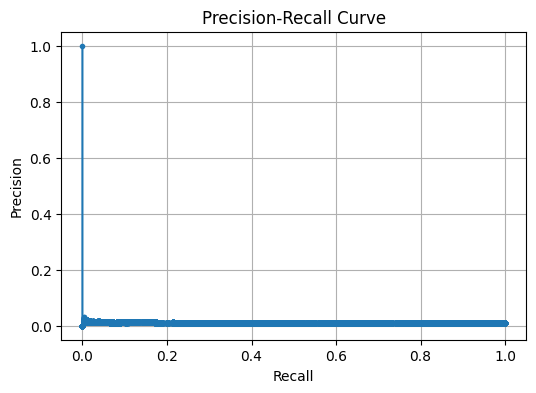

In [35]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

print("AUC: {:.4f}".format(roc_auc_score(y_test, y_proba)))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


## Feature Importances

Interpret which features (including dummies for categories) are most influential for default prediction.


In [36]:
coefs = pd.Series(clf.coef_[0], index=X.columns)
coefs.abs().sort_values(ascending=False).head(20)


item_category_Cat6          0.564773
email_host_Yahoo            0.493543
os_Other                    0.482738
month_Jun16                 0.461007
item_category_Cat14         0.415680
item_category_Cat13         0.382228
month_Dec15                 0.349744
order_amount_quintile_Q2    0.345071
month_May16                 0.327414
checkout_time_Night         0.307784
month_Nov15                 0.294335
credit_score_quintile_Q5    0.291432
item_category_Cat5          0.286475
item_category_Cat11         0.283353
month_Sep16                 0.272444
item_category_Cat2          0.272072
channel_Do-not-track        0.261979
item_category_Cat12         0.251808
device_type_Mobile          0.246319
month_Aug16                 0.240732
dtype: float64

## XGBoost

We fit an XGBoost classifier, which is robust to class imbalance, non-linearities, and categorical variable encoding (after one-hot/dummy transform).


In [37]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),  # balances classes
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)
xgb_clf.fit(X_train, y_train)
y_xgb_pred = xgb_clf.predict(X_test)
y_xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]
print("XGBoost AUC: {:.4f}".format(roc_auc_score(y_test, y_xgb_proba)))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_xgb_pred))
print("XGBoost Report:\n", classification_report(y_test, y_xgb_pred, digits=4))


/home/frederickerleigh/Dokumente/Fintech Seminar/NewCode/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:52:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost AUC: 0.4952
XGBoost Confusion Matrix:
 [[28529  1191]
 [  275     5]]
XGBoost Report:
               precision    recall  f1-score   support

           0     0.9905    0.9599    0.9750     29720
           1     0.0042    0.0179    0.0068       280

    accuracy                         0.9511     30000
   macro avg     0.4973    0.4889    0.4909     30000
weighted avg     0.9812    0.9511    0.9659     30000



## Model Comparison and Interpretation

- **Logistic Regression** is interpretable, robust, and standard in the field.
- **XGBoost** may yield higher predictive performance (especially for rare defaults) but is less interpretable.
- All categorical variables are handled by one-hot encoding (reference categories omitted).
- Evaluation metrics (AUC, precision, recall, confusion matrix) are shown for both.

> *Use AUC for model ranking; check confusion matrices and precision-recall for business relevance!*
